In [40]:
!pip install -U datasets


In [41]:
from datasets import load_dataset

ds = load_dataset(
    "allenai/qasper",
    revision="refs/convert/parquet"
)

print(ds)


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'abstract', 'full_text', 'qas', 'figures_and_tables'],
        num_rows: 888
    })
    validation: Dataset({
        features: ['id', 'title', 'abstract', 'full_text', 'qas', 'figures_and_tables'],
        num_rows: 281
    })
    test: Dataset({
        features: ['id', 'title', 'abstract', 'full_text', 'qas', 'figures_and_tables'],
        num_rows: 416
    })
})


In [42]:
train_ds = ds["train"]
print(len(train_ds))
train_ds[0]


888


{'id': '1909.00694',
 'title': 'Minimally Supervised Learning of Affective Events Using Discourse Relations',
 'abstract': 'Recognizing affective events that trigger positive or negative sentiment has a wide range of natural language processing applications but remains a challenging problem mainly because the polarity of an event is not necessarily predictable from its constituent words. In this paper, we propose to propagate affective polarity using discourse relations. Our method is simple and only requires a very small seed lexicon and a large raw corpus. Our experiments using Japanese data show that our method learns affective events effectively without manually labeled data. It also improves supervised learning results when labeled data are small.',
 'full_text': {'section_name': ['Introduction',
   'Related Work',
   'Proposed Method',
   'Proposed Method ::: Polarity Function',
   'Proposed Method ::: Discourse Relation-Based Event Pairs',
   'Proposed Method ::: Discourse Relat

In [43]:
sample = train_ds[0]
sample.keys()


dict_keys(['id', 'title', 'abstract', 'full_text', 'qas', 'figures_and_tables'])

In [44]:
sample_qas = train_ds[0]["qas"]["question"][0]
sample_qas

'What is the seed lexicon?'

In [45]:
qas = train_ds[0]["qas"]

for i in range(len(qas["question"])):
    print(f"Question: {qas["question"][i]}")
    # Access the first free_form_answer for the current question
    if len(qas["answers"]) > i and len(qas["answers"][i]["answer"]) > 0:
        print(f"Answer: {qas["answers"][i]["answer"][0]["free_form_answer"]}")
    else:
        print("Answer: Not available or unanswerable.")

Question: What is the seed lexicon?
Answer: a vocabulary of positive and negative predicates that helps determine the polarity score of an event
Question: What are the results?
Answer: Using all data to train: AL -- BiGRU achieved 0.843 accuracy, AL -- BERT achieved 0.863 accuracy, AL+CA+CO -- BiGRU achieved 0.866 accuracy, AL+CA+CO -- BERT achieved 0.835, accuracy, ACP -- BiGRU achieved 0.919 accuracy, ACP -- BERT achived 0.933, accuracy, ACP+AL+CA+CO -- BiGRU achieved 0.917 accuracy, ACP+AL+CA+CO -- BERT achieved 0.913 accuracy. 
Using a subset to train: BERT achieved 0.876 accuracy using ACP (6K), BERT achieved 0.886 accuracy using ACP (6K) + AL, BiGRU achieved 0.830 accuracy using ACP (6K), BiGRU achieved 0.879 accuracy using ACP (6K) + AL + CA + CO.
Question: How are relations used to propagate polarity?
Answer: based on the relation between events, the suggested polarity of one event can determine the possible polarity of the other event 
Question: How big is the Japanese data?
A

#Preprocessing

In [46]:
processed_data = []

for item in train_ds:
    paper_id = item["id"]
    title = item["title"]
    abstract = item["abstract"]
    context = item["full_text"]

    qas_data = item["qas"]

    for i in range(len(qas_data["question"])):
        question = qas_data["question"][i]

        answer = ""
        # Check if there's an answer entry for this question index
        if i < len(qas_data["answers"]) and len(qas_data["answers"][i]["answer"]) > 0:
            # Get the free_form_answer from the first answer object
            answer = qas_data["answers"][i]["answer"][0]["free_form_answer"]

        # Note: 'answer_type' is not directly available at this level of the 'qas' structure
        # and would need to be inferred or extracted from the 'answer' object if needed.

        processed_data.append({
            "paper_id": paper_id,
            "title": title,
            "abstract": abstract,
            "question": question,
            "answer": answer,
            "context": context
        })

In [47]:
import pandas as pd

df = pd.DataFrame(processed_data)
df.head()


,paper_id,title,abstract,question,answer,context
0,1909.00694,Minimally Supervised Learning of Affective Eve...,Recognizing affective events that trigger posi...,What is the seed lexicon?,a vocabulary of positive and negative predicat...,"{'section_name': ['Introduction', 'Related Wor..."
1,1909.00694,Minimally Supervised Learning of Affective Eve...,Recognizing affective events that trigger posi...,What are the results?,Using all data to train: AL -- BiGRU achieved ...,"{'section_name': ['Introduction', 'Related Wor..."
2,1909.00694,Minimally Supervised Learning of Affective Eve...,Recognizing affective events that trigger posi...,How are relations used to propagate polarity?,"based on the relation between events, the sugg...","{'section_name': ['Introduction', 'Related Wor..."
3,1909.00694,Minimally Supervised Learning of Affective Eve...,Recognizing affective events that trigger posi...,How big is the Japanese data?,7000000 pairs of events were extracted from th...,"{'section_name': ['Introduction', 'Related Wor..."
4,1909.00694,Minimally Supervised Learning of Affective Eve...,Recognizing affective events that trigger posi...,What are labels available in dataset for super...,,"{'section_name': ['Introduction', 'Related Wor..."


In [48]:
df.isnull().sum()


,0
paper_id,0
title,0
abstract,0
question,0
answer,0
context,0


In [49]:
df = df[df["answer"].str.len() > 0]


In [50]:
df["question_length"] = df["question"].apply(lambda x: len(x.split()))
df["answer_length"]   = df["answer"].apply(lambda x: len(x.split()))
df["context_length"]  = df["context"].apply(lambda x: len(' '.join([' '.join(section) for section in x['paragraphs']]).split()))

#DATA VISUALIZATION PART

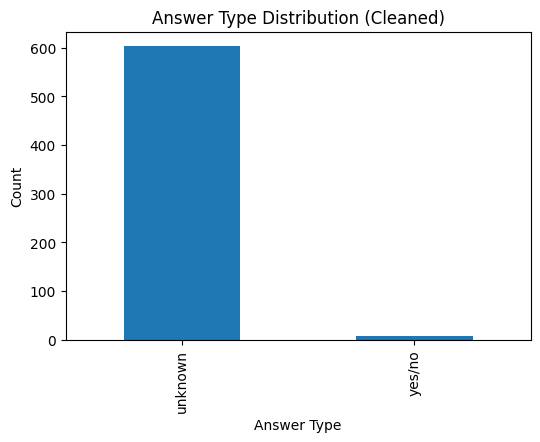

In [51]:
import matplotlib.pyplot as plt

df["answer"].unique()

def clean_answer(x):
    if not isinstance(x, str):
        return "unknown"
    x = x.lower()
    if "extractive" in x:
        return "extractive"
    elif "abstractive" in x:
        return "abstractive"
    elif "yes" in x:
        return "yes/no"
    elif "unanswerable" in x:
        return "unanswerable"
    else:
        return "unknown"

df["answer_clean"] = df["answer"].apply(clean_answer)



counts = df["answer_clean"].value_counts()

plt.figure(figsize=(6,4))
counts.plot(kind="bar")
plt.title("Answer Type Distribution (Cleaned)")
plt.xlabel("Answer Type")
plt.ylabel("Count")
plt.show()



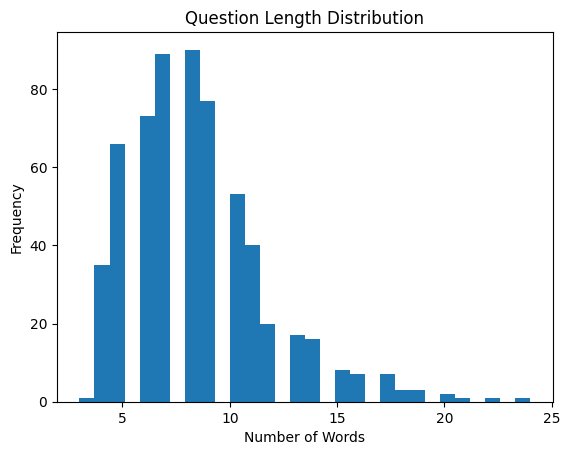

In [52]:
plt.hist(df["question_length"], bins=30)
plt.title("Question Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


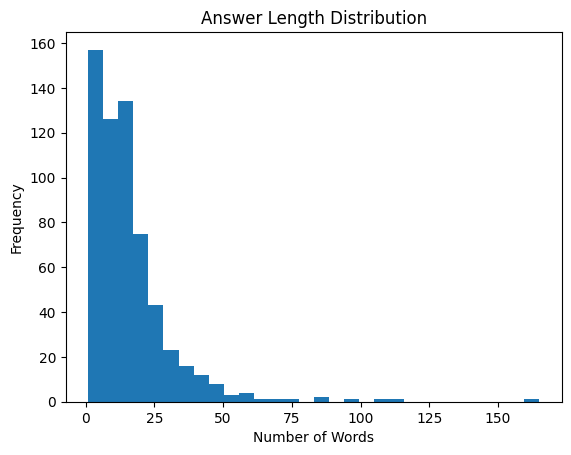

In [53]:
plt.hist(df["answer_length"], bins=30)
plt.title("Answer Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


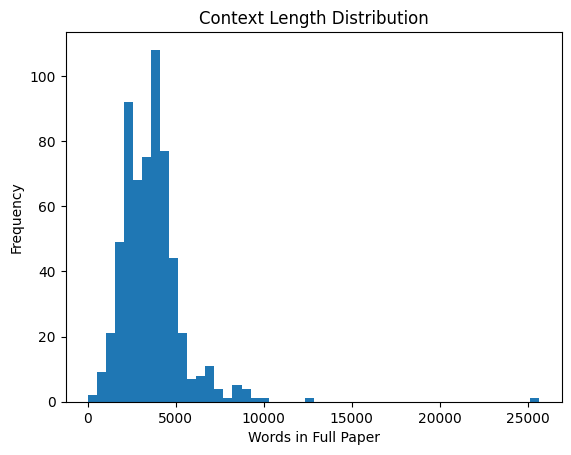

In [54]:
plt.hist(df["context_length"], bins=50)
plt.title("Context Length Distribution")
plt.xlabel("Words in Full Paper")
plt.ylabel("Frequency")
plt.show()


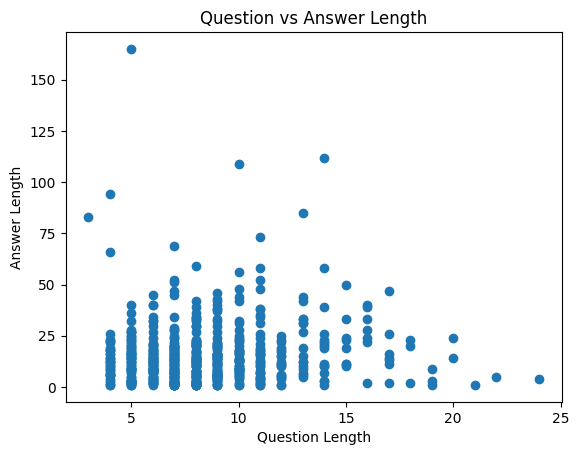

In [55]:
plt.scatter(df["question_length"], df["answer_length"])
plt.xlabel("Question Length")
plt.ylabel("Answer Length")
plt.title("Question vs Answer Length")
plt.show()


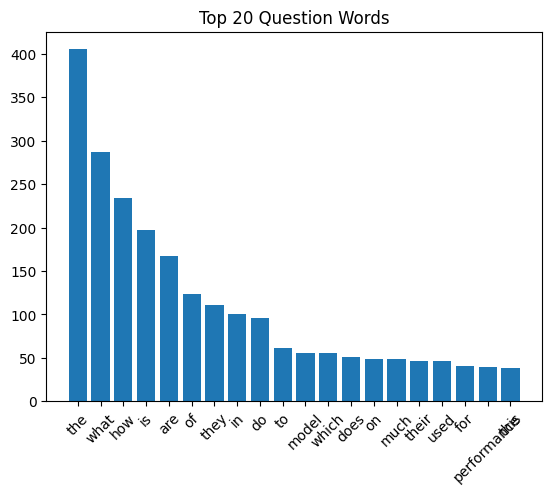

In [56]:
from collections import Counter

all_questions = " ".join(df["question"])
words = all_questions.lower().split()

common_words = Counter(words).most_common(20)

words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Question Words")
plt.show()


#Text Chunking

In [57]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "sentence-transformers/all-mpnet-base-v2"
)

def chunk_text(text, chunk_size=300, overlap=50):
    words = text.split()
    chunks = []
    start = 0

    while start < len(words):
        chunk = words[start : start + chunk_size]
        chunks.append(" ".join(chunk))
        start += chunk_size - overlap

    return chunks


#Apply Chunking on Context

In [58]:
all_chunks = []
metadata = []

for idx, row in df.iterrows():
    # Extract and join the text from 'paragraphs' list within the 'context' dictionary
    full_text_content = ' '.join([' '.join(section) for section in row["context"]['paragraphs']])
    chunks = chunk_text(full_text_content)

    for ch in chunks:
        all_chunks.append(ch)
        metadata.append({
            "paper_id": row["paper_id"],
            "question": row["question"]
        })

In [59]:
!pip install sentence-transformers faiss-cpu


#Text Embeddings

In [60]:
from sentence_transformers import SentenceTransformer

embed_model = SentenceTransformer("all-mpnet-base-v2")

embeddings = embed_model.encode(
    all_chunks,
    show_progress_bar=True
)


Batches:   0%|          | 0/287 [00:00<?, ?it/s]

#Create FAISS Index

In [61]:
import faiss
import numpy as np

dimension = embeddings.shape[1]

index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings))

print("Total vectors:", index.ntotal)


Total vectors: 9168


#Save FAISS Index

In [62]:
faiss.write_index(index, "qasper_faiss.index")


#Similarity Search Function

In [63]:
def retrieve_chunks(query, k=5):
    q_emb = embed_model.encode([query])
    D, I = index.search(np.array(q_emb), k)
    return [all_chunks[i] for i in I[0]]


#LLM-based RAG Pipeline

In [64]:
def build_prompt(question, contexts):
    context_text = "\n\n".join(contexts)
    prompt = f"""
You are an AI assistant answering questions from research papers.

Context:
{context_text}

Question:
{question}

Answer clearly and concisely.
"""
    return prompt


#LLM Answer (HuggingFace / OpenAI compatible)

In [65]:
from transformers import pipeline

llm = pipeline(
    "text-generation",
    model="google/flan-t5-base",
    max_new_tokens=200
)

def rag_answer(question):
    contexts = retrieve_chunks(question)
    prompt = build_prompt(question, contexts)
    result = llm(prompt)
    return result[0]["generated_text"]


Device set to use cpu
The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'ApertusForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'BltForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV2ForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'DogeForCausalLM', 'Dots1ForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'Ernie4_5ForCausalLM', 'Ernie4_5_MoeForCausalLM', 'Exaone4ForCausalLM', 'FalconForCausalLM', 'FalconH1ForCausalLM', 'FalconMambaForCausalLM', 'FlexOlmoF

In [66]:
rag_answer("What is the main contribution of the paper?")


Token indices sequence length is longer than the specified maximum sequence length for this model (1958 > 512). Running this sequence through the model will result in indexing errors


"\nYou are an AI assistant answering questions from research papers.\n\nContext:\n(middle initials are allowed). Do not format surnames in all capitals (e.g., use “Mitchell” not “MITCHELL”). Do not format title and section headings in all capitals as well except for proper names (such as “BLEU”) that are conventionally in all capitals. The affiliation should contain the author's complete address, and if possible, an electronic mail address. Start the body of the first page 7.5 cm from the top of the page. The title, author names and addresses should be completely identical to those entered to the electronical paper submission website in order to maintain the consistency of author information among all publications of the conference. If they are different, the publication chairs may resolve the difference without consulting with you; so it is in your own interest to double-check that the information is consistent. Abstract: Type the abstract at the beginning of the first column. The wid

#Training Data Format

In [67]:
def format_qa(row):
    return {
        "input_text": f"question: {row['question']} context: {row['context']}",
        "target_text": row["answer"]
    }

# Determine the actual number of samples to take
num_samples = min(3000, len(df))

# Sample the DataFrame
train_data = df.sample(n=num_samples, random_state=42).apply(format_qa, axis=1).tolist()

#Tokenization

In [68]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")

def tokenize(batch):
    inputs = tokenizer(
        batch["input_text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )
    targets = tokenizer(
        batch["target_text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    inputs["labels"] = targets["input_ids"]
    return inputs


#Trainer

In [69]:
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments

model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

args = TrainingArguments(
    output_dir="./qasper_ft",
    per_device_train_batch_size=2,
    num_train_epochs=2,
    logging_steps=100,
    save_steps=500
)


#Gradio UI (Chatbot)

In [70]:
import gradio as gr

def chatbot(question, history):
    answer = rag_answer(question)
    history.append((question, answer))
    return history, ""

with gr.Blocks(title="Research Paper Q&A Bot") as demo:

    gr.Markdown("""
    # 📄 Research Paper Q&A Bot (QASPER)
    Ask questions about research papers using **LLM + FAISS (RAG pipeline)**.

    🔹 Powered by QASPER Dataset
    🔹 Supports long research papers
    🔹 Evidence-based answers
    """)

    chatbot_ui = gr.Chatbot(
        label="💬 Chat",
        height=400
    )

    with gr.Row():
        question_box = gr.Textbox(
            placeholder="Ask a question about the paper...",
            label="Your Question",
            lines=2
        )

    with gr.Row():
        submit_btn = gr.Button("🚀 Ask")
        clear_btn = gr.Button("🧹 Clear")

    gr.Markdown("""
    ### 🧪 Example Questions
    - What is the main contribution of the paper?
    - What dataset is used in the experiments?
    - What evaluation metrics are used?
    - Does the paper compare with previous methods?
    """)

    submit_btn.click(
        fn=chatbot,
        inputs=[question_box, chatbot_ui],
        outputs=[chatbot_ui, question_box]
    )

    question_box.submit(
        fn=chatbot,
        inputs=[question_box, chatbot_ui],
        outputs=[chatbot_ui, question_box]
    )

    clear_btn.click(
        fn=lambda: [],
        outputs=chatbot_ui
    )

demo.launch()


/tmp/ipython-input-1188530517.py:19: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot_ui = gr.Chatbot(
/tmp/ipython-input-1188530517.py:19: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chatbot_ui = gr.Chatbot(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a70e72c612e31d1412.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
